In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

import re
import pandas as pd
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

23/06/26 20:35:13 WARN Utils: Your hostname, Xinyis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.201 instead (on interface en0)
23/06/26 20:35:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/26 20:35:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Users/jwang/opt/anaconda3/envs/DDS/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from transformation import *

# Loading and Parsing NASA Log Dataset

In [3]:
input_file_path = ''
input_df = zip_log_to_df(input_file_path, spark)
input_df.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

In [4]:
# split the rows to columns
df = split_to_df(input_df,ts_pattern1)
df.show(10, truncate=True)

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

# Handling Missing Data 

## Count Missing Values

In [8]:
# count the total number of rows has missing values
count_null(df)

33905

In [6]:
# count the number of missing values for each column
count_null_cols(df).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



## Show Missing Values

In [9]:
null_status_df = input_df.filter(~input_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



## Drop Missing Values 

We can pass the records with missing values.

In [10]:
df_clean = fill_null_values(df)

In [12]:
# count null values after cleaning
count_null_cols(df_clean).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



Missing values are droped. 

# Data Engineering

## Format Timestamp

In [13]:
# format timpstamp to year-month-date format
df = month_to_num(df_clean)
df = format_timestamp(df)
df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


# Data Analysis 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import functions as F
%matplotlib inline

## Content Size

In [14]:
# explore the distribution of content size
content_size_summary_df = df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


## HTTP Status

In [17]:
# explore the distribution of HTTP Status

def plot_status(df):
    status_freq_df = (df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
    status_freq_pd_df = (status_freq_df
                         .toPandas()
                         .sort_values(by=['count'],
                                      ascending=False))
    sns.catplot(x='status', y='count', data=status_freq_pd_df, 
            kind='bar', order=status_freq_pd_df['status'])
    return status_freq_df


def plot_log_status(df):
    status_freq_df = (df
                     .groupBy('status')
                     .count()
                     .sort('status')
                     .cache())
    log_freq_df = status_freq_df.withColumn('log(count)', F.log(status_freq_df['count']))
    log_freq_pd_df = (log_freq_df
                         .toPandas()
                         .sort_values(by=['log(count)'],
                                      ascending=False))
    sns.catplot(x='status', y='log(count)', data=log_freq_pd_df, 
            kind='bar', order=log_freq_pd_df['status'])
    return status_freq_df

23/06/26 20:45:47 WARN CacheManager: Asked to cache already cached data.


DataFrame[status: int, count: bigint]

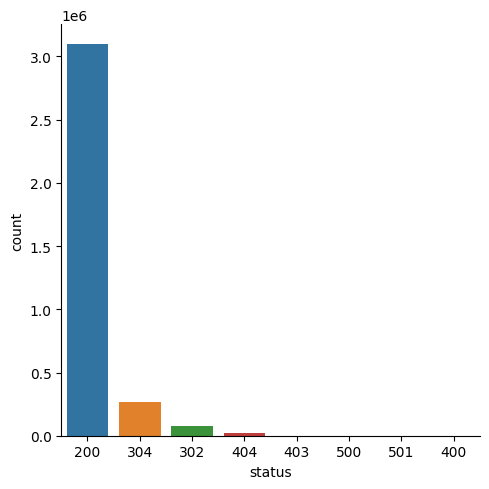

In [18]:
# explore the distribution of HTTP Status and order by count

plot_status(df)

23/06/26 20:47:03 WARN CacheManager: Asked to cache already cached data.


DataFrame[status: int, count: bigint]

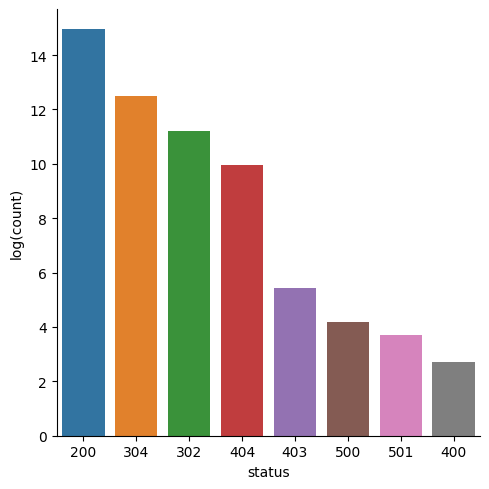

In [19]:
# as the skewed distribution, plot count in log scale
plot_log_status(df)

## Frequent Host
Count the accesses by each host, ordered and obtain the top 10

In [20]:
top_host(df, 5).show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
+--------------------+-----+



## Top EndPoint 
Explore the top frequent endpoints

In [21]:
top_endpoint(df,10).show(truncate=False)

+---------------------------------------+------+
|endpoint                               |count |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |208714|
|/images/KSC-logosmall.gif              |164970|
|/images/MOSAIC-logosmall.gif           |127908|
|/images/USA-logosmall.gif              |127074|
|/images/WORLD-logosmall.gif            |125925|
|/images/ksclogo-medium.gif             |121572|
|/ksc.html                              |83909 |
|/images/launch-logo.gif                |76006 |
|/history/apollo/images/apollo-logo1.gif|68896 |
|/shuttle/countdown/                    |64736 |
+---------------------------------------+------+



## Total number of unique host
get the unique host and cout the total number

In [22]:
df.select('host').distinct().count()

137933

## Number of unique daily hosts
Explore the unique host of each day of month

In [28]:
# get the month of day
host_day_df = df.select(df.host, F.dayofmonth('time').alias('day'))
host_day_distinct_df = (host_day_df.dropDuplicates())
# aggregate by the day of month
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .sort("day"))
daily_hosts_df.show(truncate=False)

+---+-----+
|day|count|
+---+-----+
|1  |7609 |
|2  |4858 |
|3  |10238|
|4  |9411 |
|5  |9640 |
|6  |10133|
|7  |10048|
|8  |7112 |
|9  |6699 |
|10 |8532 |
|11 |8786 |
|12 |8135 |
|13 |9567 |
|14 |9302 |
|15 |7126 |
|16 |7143 |
|17 |8840 |
|18 |8262 |
|19 |7237 |
|20 |7072 |
+---+-----+
only showing top 20 rows



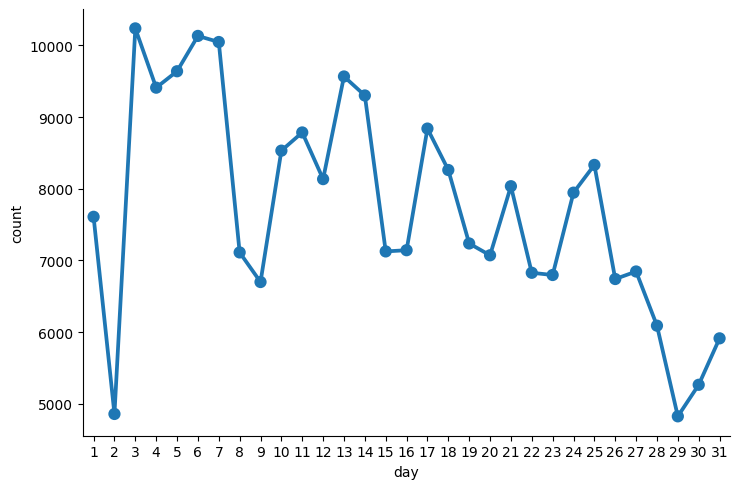

In [29]:
# plot the distribution of daily unique host
daily_hosts_df = daily_hosts_df.toPandas()
c = sns.catplot(x='day', y='count', 
                data=daily_hosts_df, 
                kind='point', height=5, 
                aspect=1.5)

## Average Number of daily request per host 
explore the average request number for each host

In [34]:

# total number of host per day
daily_hosts_df = (host_day_distinct_df
                     .groupBy('day')
                     .count()
                     .select(col("day"), 
                                      col("count").alias("total_hosts")))
# total number of requests
total_daily_reqests_df = (df
                              .select(F.dayofmonth("time")
                                          .alias("day"))
                              .groupBy("day")
                              .count()
                              .select(col("day"), 
                                      col("count").alias("total_reqs")))
# get the average daily request per host by total requests / total hosts
avg_daily_reqests_per_host_df = total_daily_reqests_df.join(daily_hosts_df, 'day')
avg_daily_reqests_per_host_df = (avg_daily_reqests_per_host_df
                                    .withColumn('avg_reqs', col('total_reqs') / col('total_hosts'))
                                    .sort("day"))
avg_daily_reqests_per_host_df = avg_daily_reqests_per_host_df.toPandas()
avg_daily_reqests_per_host_df

,day,total_reqs,total_hosts,avg_reqs
0,1,98710,7609,12.972795
1,2,60265,4858,12.405311
2,3,130972,10238,12.792733
3,4,130009,9411,13.814579
4,5,126468,9640,13.119087
5,6,133380,10133,13.162933
6,7,144595,10048,14.390426
7,8,99024,7112,13.923510
8,9,95730,6699,14.290193
9,10,134108,8532,15.718237


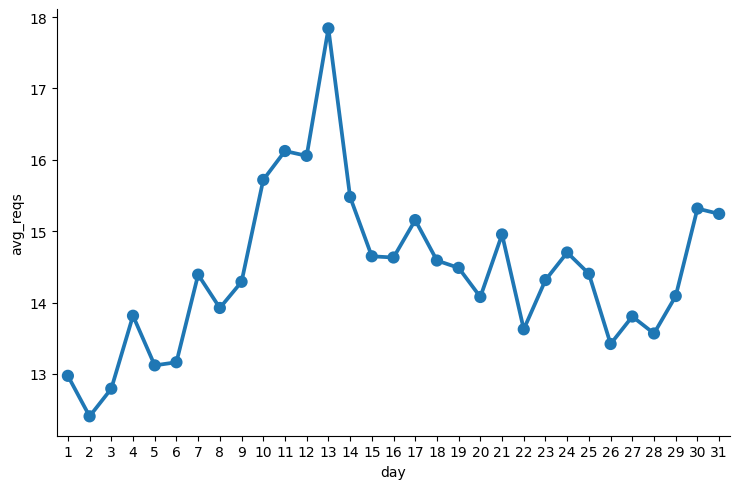

In [35]:
# plot the result
c = sns.catplot(x='day', y='avg_reqs', 
                data=avg_daily_reqests_per_host_df, 
                kind='point', height=5, aspect=1.5)

## 404 response
Filter the 404 responses 

### Total Count

In [43]:
# cache the result RDD, since we will use it repeately
not_found_df = df.filter(df["status"] == 404).cache()
print(('Total 404 responses: {}').format(not_found_df.count()))

23/06/26 21:20:17 WARN CacheManager: Asked to cache already cached data.
Total 404 responses: 20899


### Top 404 Response Code Endpoints
Filter the 404 responses and aggregate by endpoints

In [38]:

endpoints_404_count_df = (not_found_df
                          .groupBy("endpoint")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

endpoints_404_count_df.show(truncate=False)

+-----------------------------------------------------------------+-----+
|endpoint                                                         |count|
+-----------------------------------------------------------------+-----+
|/pub/winvn/readme.txt                                            |2004 |
|/pub/winvn/release.txt                                           |1732 |
|/shuttle/missions/STS-69/mission-STS-69.html                     |683  |
|/shuttle/missions/sts-68/ksc-upclose.gif                         |428  |
|/history/apollo/a-001/a-001-patch-small.gif                      |384  |
|/history/apollo/sa-1/sa-1-patch-small.gif                        |383  |
|/://spacelink.msfc.nasa.gov                                      |381  |
|/images/crawlerway-logo.gif                                      |374  |
|/elv/DELTA/uncons.htm                                            |372  |
|/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif|359  |
|/images/nasa-logo.gif                

### Top 404 Response Code Hosts
Filter the 404 responses and aggregate by host

In [39]:

hosts_404_count_df = (not_found_df
                          .groupBy("host")
                          .count()
                          .sort("count", ascending=False)
                          .limit(20))

hosts_404_count_df.show(truncate=False)

+---------------------------+-----+
|host                       |count|
+---------------------------+-----+
|hoohoo.ncsa.uiuc.edu       |251  |
|piweba3y.prodigy.com       |157  |
|jbiagioni.npt.nuwc.navy.mil|132  |
|piweba1y.prodigy.com       |114  |
|                           |112  |
|www-d4.proxy.aol.com       |91   |
|piweba4y.prodigy.com       |86   |
|scooter.pa-x.dec.com       |69   |
|www-d1.proxy.aol.com       |64   |
|phaelon.ksc.nasa.gov       |64   |
|www-b4.proxy.aol.com       |62   |
|dialip-217.den.mmc.com     |62   |
|www-b3.proxy.aol.com       |61   |
|www-a2.proxy.aol.com       |60   |
|piweba2y.prodigy.com       |59   |
|www-d2.proxy.aol.com       |59   |
|alyssa.prodigy.com         |56   |
|monarch.eng.buffalo.edu    |56   |
|www-b2.proxy.aol.com       |53   |
|www-c4.proxy.aol.com       |53   |
+---------------------------+-----+



### 404 errors per day

In [40]:
# get the 404 errors count by day
errors_by_date_sorted_df = (not_found_df
                                .groupBy(F.dayofmonth('time').alias('day'))
                                .count()
                                .sort("day"))

errors_by_date_sorted_pd_df = errors_by_date_sorted_df.toPandas()

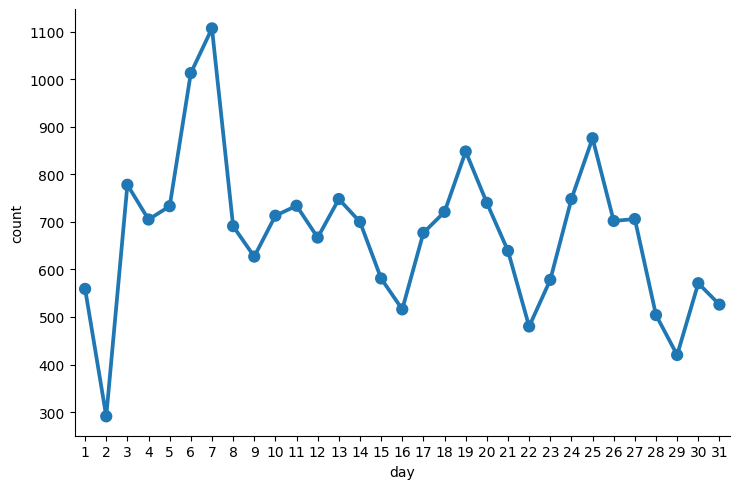

In [41]:

c = sns.catplot(x='day', y='count', 
                data=errors_by_date_sorted_pd_df, 
                kind='point', height=5, aspect=1.5)

### top 404 responses days
get the top three days with 404 errors

In [42]:
(errors_by_date_sorted_df
    .sort("count", ascending=False)
    .show(3))

+---+-----+
|day|count|
+---+-----+
|  7| 1107|
|  6| 1013|
| 25|  876|
+---+-----+
only showing top 3 rows



### distribution of 404 errors count by hour
obtain hour information from time stamp and aggregate by hour

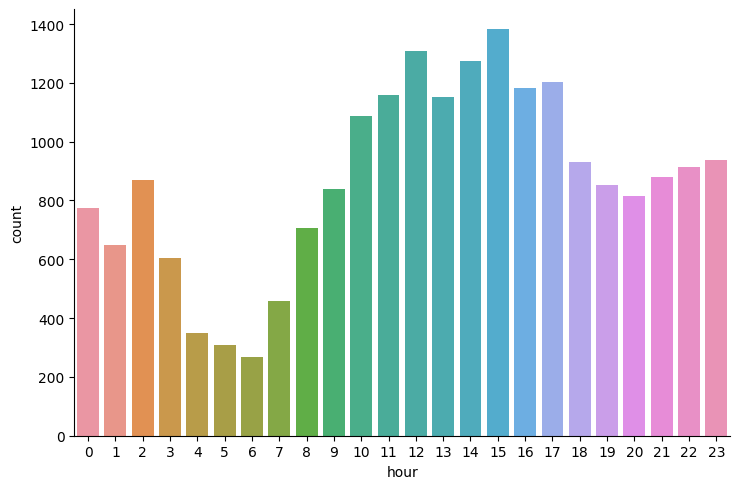

In [44]:
hourly_avg_errors_sorted_df = (not_found_df
                                   .groupBy(F.hour('time')
                                             .alias('hour'))
                                   .count()
                                   .sort('hour'))
hourly_avg_errors_sorted_pd_df = hourly_avg_errors_sorted_df.toPandas()

c = sns.catplot(x='hour', y='count', 
                data=hourly_avg_errors_sorted_pd_df, 
                kind='bar', height=5, aspect=1.5)

## 3.1 Top EndPoints by day of week
Get the day of week from timestamp, 
group by the day of week and host,
and use the window function get the top endpoint with the most count(rank 1) when partitioned by the day of week.   
The function is in the transformation.py.

In [45]:
result = top_endpoint_by_day(df)
result.show(7, truncate=False)

+--------------------------+-----+-------------+
|endpoint                  |count|Day in a week|
+--------------------------+-----+-------------+
|/images/KSC-logosmall.gif |15218|Sunday       |
|/images/NASA-logosmall.gif|30380|Monday       |
|/images/NASA-logosmall.gif|33685|Tuesday      |
|/images/NASA-logosmall.gif|37598|Wednesday    |
|/images/NASA-logosmall.gif|46920|Thursday     |
|/images/NASA-logosmall.gif|29139|Friday       |
|/images/NASA-logosmall.gif|16168|Saturday     |
+--------------------------+-----+-------------+



## 3.2 404 status count by day of week
Filter the records with 404 status and groupby the day of week

In [46]:
error_by_day = error_count_by_day(df)
error_by_day.show(7, truncate=False)

+-----+-------------+
|count|Day in a week|
+-----+-------------+
|2400 |Sunday       |
|3145 |Monday       |
|3425 |Tuesday      |
|3397 |Wednesday    |
|3772 |Thursday     |
|2691 |Friday       |
|2069 |Saturday     |
+-----+-------------+



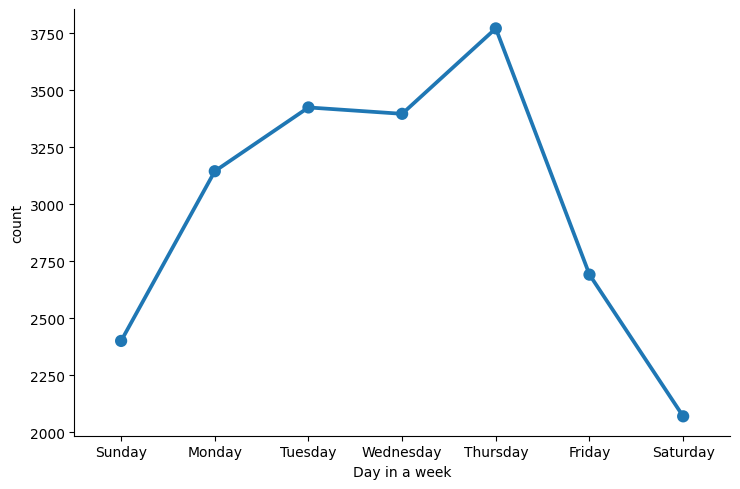

23/06/26 23:45:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 926334 ms exceeds timeout 120000 ms
23/06/26 23:45:24 WARN SparkContext: Killing executors is not supported by current scheduler.


In [47]:
sns.catplot(x='Day in a week', y='count', 
                data=error_by_day.toPandas(), 
                kind='point', height=5, 
                aspect=1.5)